## Before proceeding please download the simulations trip files from https://sync.academiccloud.de/index.php/s/6a5NVqVF7rkI3w4, and extract them into ./config as they are too large to be hosted directly on GitHub

In [1]:
import numpy as np

from src.simulation.sim_core import simulation_core
from src.torch_geo.dataset.adaptive_speed2vec_dataset import adaptive_speed2vec_dataset
from src.generator.detector_node_connector import distance_connector_strategy
from src.simulation.modules.progress_module import progress_module
from src.simulation.modules.simulationFlowControlModule import simulationFlowControlModule
from src.torch_geo.model.trainer import model_train
from src.utils.math_utils import un_z_score

from torch_geometric.loader import DataLoader
from matplotlib import pyplot as plt
import torch, random, sumolib, traci

Create and set up settings

In [4]:
settings: dict = {
    # ----- framework settings -----
    "sumo_exec_path": "<path>",
    "sumo_config_path": "./config/osm.sumocfg",
    "sumo_net_path": "./config/osm.net.xml.gz",

    # one day: 86400
    # one week: 604800
    # 777600
    # one month: 2419200
    "sim_length": 86400,  # total length of the simulation
    "interval_length": 300,  # size of one aggregation step

    # ----- model settings -----
    "N_HIST": 12,  # for Speed2Vec dataset, number of preceding steps
    "N_PRED": 9,  # for Speed2Vec dataset, number of prediction steps
    'WEIGHT_DECAY': 5e-5,
    'INITIAL_LR': 3e-4,
    'DROPOUT': 0.6,
    'CHECKPOINT_DIR': './runs',

    'BATCH_SIZE': 50,
    'EPOCHS': 60,
    'N_NODE': 274
}
settings["total_graphs"] = int(settings["sim_length"]) // int(settings["interval_length"])

Create simulation core object and add observers

In [5]:
core = simulation_core(settings, distance_connector_strategy(50))

observer_1 = progress_module(settings["sim_length"] // 100)
observer_2 = simulationFlowControlModule(60)

core.add_continuous_observer(observer_1)
core.add_continuous_observer(observer_2)

 Retrying in 1 seconds
***Starting server on port 45049 ***


Loading net-file from './config/osm.net.xml.gz' ... done (61ms).
Loading additional-files from './config/osm.poly.xml.gz' ... done (10ms).
Loading additional-files from './config/detectors_filtered.xml' ... done (2ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.
[Translation Generator] - Generating dictionaries...
[Translation Controller] - Successfully initialized!
[Detector Graph Controller] - Generating graph, this can take a while...
[Detector Graph Controller] - Graph complete! Nodes: 274 Edges: 2338
[Numpy Graph Store] - Created node features: (288, 274)
[Numpy Graph Store] - Created edge index: (2, 2338)
[Numpy Graph Store] - Successfully initialized!
[Numpy Graph Controller] - Initialized!
0


Start simulation

In [6]:
core.start_simulation()

----- 2 % -----
sim_step: 1729.0
last_sim_time: 0.12 seconds
scale: 0.1791411531690401
ETA: 0.2 minutes
----- 3 % -----
sim_step: 2593.0
last_sim_time: 0.22 seconds
scale: 0.17880370768145412
ETA: 0.28 minutes
----- 4 % -----
sim_step: 3457.0
last_sim_time: 0.15 seconds
scale: 0.162346356184341
ETA: 0.26 minutes
-----DONG, DONG, DONG-----
Passed one hour!
Day: 0 Hour: 1
Flow between 0.1 and 0.2
----- 5 % -----
sim_step: 4321.0
last_sim_time: 0.13 seconds
scale: 0.1918022263930665
ETA: 0.25 minutes
----- 6 % -----
sim_step: 5185.0
last_sim_time: 0.13 seconds
scale: 0.19867494065745167
ETA: 0.24 minutes
----- 7 % -----
sim_step: 6049.0
last_sim_time: 0.13 seconds
scale: 0.17049442597579456
ETA: 0.23 minutes
----- 8 % -----
sim_step: 6913.0
last_sim_time: 0.18 seconds
scale: 0.1575888500682996
ETA: 0.23 minutes
-----DONG, DONG, DONG-----
Passed one hour!
Day: 0 Hour: 2
Flow between 0.1 and 0.2
----- 9 % -----
sim_step: 7777.0
last_sim_time: 0.15 seconds
scale: 0.16155216042287784
ETA: 0.2

Crate dataset from data collected by DeepSUMO

In [7]:
data = adaptive_speed2vec_dataset(core.get_data(), settings["total_graphs"])
data.process()

./processed/test_data.pt
torch.Size([2, 2338])
torch.int32


Split dataset into data loaders

(287, 274)
58


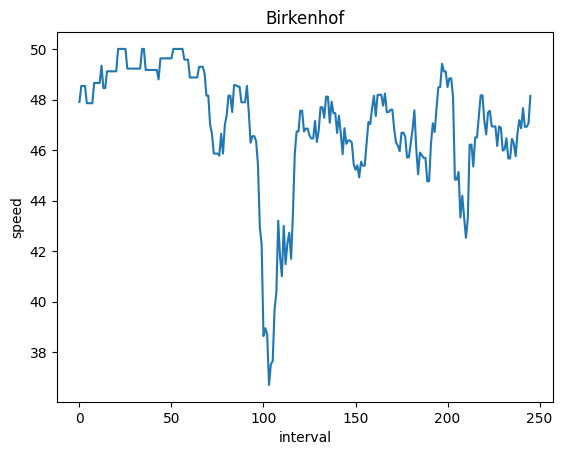

In [39]:
import numpy as np

l = []
l2 = []
buffer = []
s_id = random.randint(0, settings["N_NODE"] - 1)

print(core.get_data().numpy.get_speed_node_features().shape)
for i, point in enumerate(core.get_data().numpy.get_speed_node_features()):
    if i % 10 == 0:
        l2.append(np.average(buffer))
        buffer.clear()
    buffer.append(point[s_id] * 3.6)
    #print(point[12])
    l.append(point[s_id] * 3.6)

l = l[4:250]

print(s_id)
sumo_id = core.get_data().translation.get_detector_id(s_id)
target_lane_id = traci.inductionloop.getLaneID(sumo_id)
target_lane: sumolib.net.lane.Lane = core.get_data().net.getLane(target_lane_id)
target_edge: sumolib.net.edge.Edge = target_lane.getEdge()

plt.title(target_edge.getName())
plt.plot(range(len(l)), l)
plt.xlabel("interval")
plt.ylabel("speed")
plt.show()

0, 268

In [57]:
train_threshold = int(len(data) * 0.9)
valid_threshold = int(len(data) * 0.9)
test_threshold = int(len(data) * 1.0)

train_loader = DataLoader(data[:train_threshold], shuffle=True, batch_size=settings["BATCH_SIZE"])
valid_loader = DataLoader(data[train_threshold:test_threshold], shuffle=True, batch_size=settings["BATCH_SIZE"])
test_loader = DataLoader(data[:], shuffle=False, batch_size=settings["BATCH_SIZE"])

Set up device

In [56]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")

Using cuda


Train the model

The model used in this example is modified version of the ST-GAT model implementation by [Julie Wang](https://github.com/jswang), [Amelia](https://github.com/amelia22974) and [Tracy Cai](https://github.com/tracy-cai) which can be found [here](https://github.com/jswang/stgat_traffic_prediction).  

In [42]:
model = model_train(train_loader, valid_loader, settings, device)

Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 10.89it/s]


5
Train, MAE: 1.9260221719741821, RMSE: 2.5830018520355225, MAPE: 18.91611099243164
1
Valid, MAE: 1.8432965278625488, RMSE: 2.4855101108551025, MAPE: 18.251419067382812


Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 107.22it/s]


5
Train, MAE: 1.5371683835983276, RMSE: 2.2133023738861084, MAPE: 15.2896728515625
1
Valid, MAE: 1.4247630834579468, RMSE: 2.094492197036743, MAPE: 14.394597053527832


Epoch 10: 100%|██████████| 5/5 [00:00<00:00, 106.22it/s]


5
Train, MAE: 0.797206699848175, RMSE: 1.1621036529541016, MAPE: 7.113592624664307
1
Valid, MAE: 0.6298772096633911, RMSE: 0.9450047612190247, MAPE: 5.7516984939575195


Epoch 15: 100%|██████████| 5/5 [00:00<00:00, 109.09it/s]


5
Train, MAE: 0.6985650062561035, RMSE: 0.9848556518554688, MAPE: 6.327796459197998
1
Valid, MAE: 0.5526415109634399, RMSE: 0.7643197178840637, MAPE: 5.155633926391602


Epoch 20: 100%|██████████| 5/5 [00:00<00:00, 112.91it/s]


5
Train, MAE: 0.6788520812988281, RMSE: 0.9574567675590515, MAPE: 6.204658508300781
1
Valid, MAE: 0.5333462357521057, RMSE: 0.7443042993545532, MAPE: 5.003249168395996


Epoch 25: 100%|██████████| 5/5 [00:00<00:00, 112.96it/s]


5
Train, MAE: 0.6710476875305176, RMSE: 0.9501351714134216, MAPE: 6.1673479080200195
1
Valid, MAE: 0.5289813876152039, RMSE: 0.7379909753799438, MAPE: 4.9806294441223145


Epoch 30: 100%|██████████| 5/5 [00:00<00:00, 114.12it/s]


5
Train, MAE: 0.6781182289123535, RMSE: 0.9565231204032898, MAPE: 6.233455657958984
1
Valid, MAE: 0.5239640474319458, RMSE: 0.7352849841117859, MAPE: 4.951942443847656


Epoch 35: 100%|██████████| 5/5 [00:00<00:00, 109.20it/s]


5
Train, MAE: 0.6903829574584961, RMSE: 0.9710914492607117, MAPE: 6.267355442047119
1
Valid, MAE: 0.5275841951370239, RMSE: 0.7365560531616211, MAPE: 4.969051837921143


Epoch 40: 100%|██████████| 5/5 [00:00<00:00, 110.24it/s]


5
Train, MAE: 0.6824418902397156, RMSE: 0.9635106325149536, MAPE: 6.207705974578857
1
Valid, MAE: 0.5263136029243469, RMSE: 0.7346415519714355, MAPE: 4.953463077545166


Epoch 45: 100%|██████████| 5/5 [00:00<00:00, 110.30it/s]


5
Train, MAE: 0.686381995677948, RMSE: 0.9663559198379517, MAPE: 6.2464494705200195
1
Valid, MAE: 0.5277758836746216, RMSE: 0.7367146015167236, MAPE: 4.970078945159912


Epoch 50: 100%|██████████| 5/5 [00:00<00:00, 110.10it/s]


5
Train, MAE: 0.6586772799491882, RMSE: 0.9334012866020203, MAPE: 6.014371395111084
1
Valid, MAE: 0.5328360795974731, RMSE: 0.7395591139793396, MAPE: 5.0037922859191895


Epoch 55: 100%|██████████| 5/5 [00:00<00:00, 114.03it/s]


5
Train, MAE: 0.6182188987731934, RMSE: 0.8822941780090332, MAPE: 5.611080169677734
1
Valid, MAE: 0.5399738550186157, RMSE: 0.7424121499061584, MAPE: 5.025391578674316


Epoch 59: 100%|██████████| 5/5 [00:00<00:00, 111.98it/s]


Get predictions on testing dataset and organize them in a way, so that they can be easily plotted

In [62]:
model.eval()
model.to(device)

for i, batch in enumerate(test_loader):
    # get predictions from model
    # shape -> (batch_size * num_nodes, n_pred/n_hist)
    batch = batch.to(device)
    with torch.no_grad():
        pred = model(batch, device)
    truth = batch.y.view(pred.shape)
    
    # all values have been normalized using the z-score method,
    # so they have to be unnormalized again for evaluation
    truth = un_z_score(truth, test_loader.dataset.mean,
                       test_loader.dataset.std_dev)
    pred = un_z_score(pred, test_loader.dataset.mean,
                      test_loader.dataset.std_dev)

    truth = batch.y.view(pred.shape)
    if i == 0:
        # initialize collection variable with zeroes on first batch
        # shape -> (num_batches, batch_size * num_nodes, n_pred/n_hist)
        y_pred = torch.zeros(len(test_loader), test_loader.batch_size * settings["N_NODE"], pred.shape[1])
        y_truth = torch.zeros(len(test_loader), test_loader.batch_size * settings["N_NODE"], pred.shape[1])
    # append data from current batch to data from other batches 
    #
    # Only append until the true length of the batch in the second dimension in case
    # there are less than the max size of possible elements in the batch (can
    # only happen on the last batch)
    y_pred[i, :pred.shape[0], :] = pred
    y_truth[i, :pred.shape[0], :] = truth

# reshape into a more readable format 
# (num_batches, batch_size * num_nodes, n_pred/n_hist) 
# -> (num_intervals, n_node, n_pred/n_hist)
y_pred = y_pred.reshape(len(test_loader) * 50,
                        settings["N_NODE"], 9)
y_truth = y_truth.reshape(len(test_loader) * 50,
                          settings["N_NODE"], 9)

# cut off the last elements if there are fewer data points in the data as 
# maximum batch-size (because they are 0)
y_pred = y_pred[:len(test_loader.dataset), :, :]
y_truth = y_truth[:len(test_loader.dataset), :, :]

y_truth = un_z_score(y_truth, data.mean, data.std_dev)

Plot predictions and truth of a random detector

672


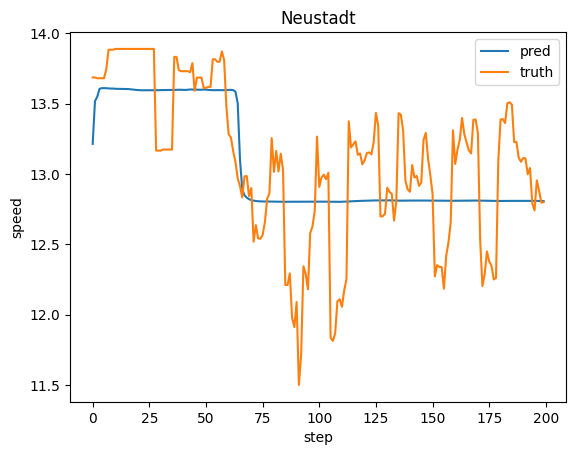

In [81]:
s1 = []
s2 = []
# get a random node
target = random.randint(0, settings["N_NODE"] - 1)
#print(core._data.translation.get_order())
#target = core._data.translation.get_index("98")

# get name of street associated with chosen detector
sumo_id = core.get_data().translation.get_detector_id(target)
target_lane_id = traci.inductionloop.getLaneID(sumo_id)
target_lane: sumolib.net.lane.Lane = core.get_data().net.getLane(target_lane_id)
target_edge: sumolib.net.edge.Edge = target_lane.getEdge()

for i in range(200):
    s1.append(y_pred[i][target][0])
    s2.append(y_truth[i][target][0])

print(sumo_id)
#print(y_pred[:][target])
#print(y_truth[:][target])

plt.title(target_edge.getName())
#plt.figure(figsize=(10,5), dpi=300)
plt.plot(range(200), s1, label='pred')
plt.plot(range(200), s2, label='truth')
plt.xlabel("step")
plt.ylabel("speed")
plt.legend()
plt.show()